In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

# from seaborn import despine
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, compute_p_choose_worst, write_summary, make_sure_path_exists

In [ ]:
make_sure_path_exists('results/linear_models')

In [ ]:
np.random.seed(52) # from random.org

# Absolute model fit (out of sample prediction)
## Like and dislike condition

In [ ]:
print('Assessing absolute model fit...')

### Load plot function

In [ ]:
def plot_correlation(x_in, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=15,
                     plot_diagonal=False,
                     color_code = ['#4F6A9A', '#AC5255'],
                     hatch_code= '',
                     ax=None):
    
    sns.set(style='white', font_scale=1.8)

    x_all = x_in
    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(x_in, list):
        x_all = [x_in]
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        
        # Select if we load the set of observed items for like (0) or dislike (1)
        # This will depend on how we define it later.
        x = x_all[i]

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        sort_idx = np.argsort(x)
        ax.plot(xs, intercept + slope * xs,
                color=color_code[i], label=label)        
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color=color_code[i], alpha=0.4, hatch=hatch_code)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color='None', alpha=1, hatch=hatch_code, edgecolor="white")
        mpl.rcParams['hatch.linewidth'] = 5  
        
        
        # Scatter
        ax.scatter(x, yi, color=color_code[i], alpha=0.8, s=100,hatch = hatch_code)
        mpl.rcParams['hatch.linewidth'] = 5


    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    else :
        ax.tick_params(labelsize=fontsize_ticklabels)

    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)
    else:
        ax.tick_params(labelsize=fontsize_ticklabels)


    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.2, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
    sns.despine()

    return ax

### Load figure function

In [29]:
def figure_correlations(mean_rt, p_choose_best, gaze_influence, figsize=(20, 7), color_code1 = ['#4F6A9A', '#AC5255'], labels = ['Like','Dislike'], model_names1 =['Like', 'Dislike'], hatch2 =''):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    # PLot legend
    patch1 = mpatches.Patch(facecolor=color_code1[0],hatch=hatch2, label=labels[0],edgecolor="white")
    patch2 = mpatches.Patch(facecolor=color_code1[1],hatch=hatch2, label=labels[1],edgecolor="white")
    mpl.rcParams['hatch.linewidth'] = 2
    leg = plt.legend(handles=[patch1,patch2],fontsize=14,loc = "lower right")
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
    plt.gca().add_artist(leg)
    
    
    
    plot_correlation([mean_rt['observed_L'].values, mean_rt['observed_D'].values], 
                     [mean_rt['glam_full_L'].values, mean_rt['glam_full_D'].values],
                     model_names=model_names1,
                     xlabel='Observed mean RT [ms]',
                     ylabel='GLAM predicted mean RT [ms]',
                     #title='Mean RT (ms)',
                     #xlim=[1000, 5500],
                     #ylim=[1000, 5500],
                    # xticks=np.arange(0, 7000, 1000),
                    # yticks=np.arange(0, 7000, 1000),
                     #xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     #yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=12,
                     ax=axs[0], plot_diagonal=True, color_code = color_code1, hatch_code = hatch2 )

    plot_correlation([p_choose_best['observed_L'].values, p_choose_best['observed_D'].values],
                     [p_choose_best['glam_full_L'].values, p_choose_best['glam_full_D'].values],
                     model_names=model_names1,
                     xlabel='Observed P(choose correct)',
                     ylabel='GLAM Predicted P(choose correct)',
                  #   title='P(choose best)',
                     xlim=[0.45, 1.],
                     ylim=[0.45, 1.],
                     xticks=np.arange(0.1, 1.1, 0.1),
                     yticks=np.arange(0.1, 1.1, 0.1),
                    # xticklabels=['0.1', '0.2', '0.3','0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                    # yticklabels=['0.1', '0.2', '0.3','0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=12,
                     ax=axs[1], plot_diagonal=True, color_code = color_code1,hatch_code = hatch2)

    plot_correlation([gaze_influence['observed_L'].values, gaze_influence['observed_D'].values],
                     [gaze_influence['glam_full_L'].values, gaze_influence['glam_full_D'].values],
                     model_names=model_names1,
                     xlabel='Observed gaze influence \non P(Choice|Value)',
                     ylabel='GLAM Predicted gaze influence \non P(Choice|Value)',
                     #title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 1, 0.1),
                     yticks=np.arange(-0.1, 1, 0.1),
                     #xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     #yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     #xlim=[-0.125, 0.625],
                     #ylim=[-0.125, 0.625],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=12,
                     ax=axs[2], plot_diagonal=True ,color_code = color_code1,hatch_code = hatch2)

    # index axes
 #   for label, ax in zip(list('ABC'), axs.ravel()):
 #       ax.text(-0.1, 1.15, label, transform=ax.transAxes,
 #               fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    
    
 

    return None

## Load *observed* data (test set) GLAM out of sample *predictions*

In [ ]:
#Like

test_data_L = pd.read_csv('data/PF2019_data/GlamDataPF2019_preprocessed_test_individual_More_NoBin_Gamma-11_NUTS_33.csv')
#glam_full_L = pd.read_csv('results/predictions/glam_PF2019_full_individual_More_NoBin_Gamma-11_NUTS_33.csv')

#Dislike Frame-Value Data
test_data_D_inv = pd.read_csv('data/PF2019_data/GlamDataPF2019_preprocessed_test_individual_Less_Inv_NoBin_Gamma-11_NUTS_33.csv')
glam_full_D_inv = pd.read_csv('results/predictions/glam_PF2019_full_individual_Less_Inv_NoBin_Gamma-11_NUTS_33.csv')

#Dislike Frame-Value Data
test_data_D = pd.read_csv('data/PF2019_data/GlamDataPF2019_preprocessed_test_individual_Less_NoBin_Gamma-11_NUTS_33.csv')
glam_full_D = pd.read_csv('results/predictions/glam_PF2019_full_individual_Less_NoBin_Gamma-11_NUTS_33.csv')




# Compute behavioral indices for observed data and predictions

In [ ]:
mean_rt = pd.DataFrame(dict(observed_L=compute_mean_rt(test_data_L),
                            observed_D=compute_mean_rt(test_data_D_inv),
                            glam_full_L=compute_mean_rt(glam_full_L),
                            glam_full_D=compute_mean_rt(glam_full_D_inv)))


# Since the correct answer in dislike frame is actually the worst item we use the alternative function
p_choose_best = pd.DataFrame(dict(observed_L=compute_p_choose_best(test_data_L),
                            observed_D=compute_p_choose_best(test_data_D_inv),
                            glam_full_L=compute_p_choose_best(glam_full_L),
                            glam_full_D=compute_p_choose_best(glam_full_D_inv)))

gaze_influence = pd.DataFrame(dict(observed_L=compute_gaze_influence(test_data_L),
                                   observed_D=compute_gaze_influence(test_data_D_inv),
                                   glam_full_L=compute_gaze_influence(glam_full_L),
                                  glam_full_D=compute_gaze_influence(glam_full_D_inv)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Like

#### 1.1 Mean RT

In [ ]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_L'],
                     mean_rt['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_rt.csv')

#### 1.2 P(choose best)

In [ ]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_L'],
                     p_choose_best['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_pchoosebest.csv')

#### 1.3 Gaze influence on P(choose left)

In [ ]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full_L'],
                     gaze_influence['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_gazeinfluence.csv')

### 2. Dislike GLAM

#### 2.1 Mean RT

In [ ]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_D'],
                     mean_rt['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_rt.csv')

#### 2.2 P(choose best)

In [ ]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_D'],
                     p_choose_best['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_pchoosebest.csv')

#### 2.3 Gaze influence on P(choose left)

In [ ]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_full_D'],
                     gaze_influence['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_gazeinfluence.csv')

In [ ]:
print('Close Figure to continue...')
figure_correlations(mean_rt, p_choose_best, gaze_influence, hatch2 ='',labels = ['Like','Dislike Frame-Value'])
#plt.savefig('SavedFigures/Like_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

Model predictions are simulated from hierarchically estimated parameter estimates. Blue color indicates predictions from the full GLAM, whereas orange indicates predictions from a restricted GLAM variant with no gaze bias (gamma = 1).



# Compute behavioral indices for observed data and predictions in the two dislike models

In [27]:
mean_rt2 = pd.DataFrame(dict(observed_L=compute_mean_rt(test_data_D_inv),
                            observed_D=compute_mean_rt(test_data_D),
                            glam_full_L=compute_mean_rt(glam_full_D_inv),
                            glam_full_D=compute_mean_rt(glam_full_D)))
                            
p_choose_best2 = pd.DataFrame(dict(observed_L=compute_p_choose_best(test_data_D_inv),
                            observed_D=compute_p_choose_best(test_data_D),
                            glam_full_L=compute_p_choose_best(glam_full_D_inv),
                            glam_full_D=compute_p_choose_best(glam_full_D)))

gaze_influence2 = pd.DataFrame(dict(observed_L=compute_gaze_influence(test_data_D_inv),
                                   observed_D=compute_gaze_influence(test_data_D),
                                   glam_full_L=compute_gaze_influence(glam_full_D_inv),
                                  glam_full_D=compute_gaze_influence(glam_full_D)))

Close Figure to continue...


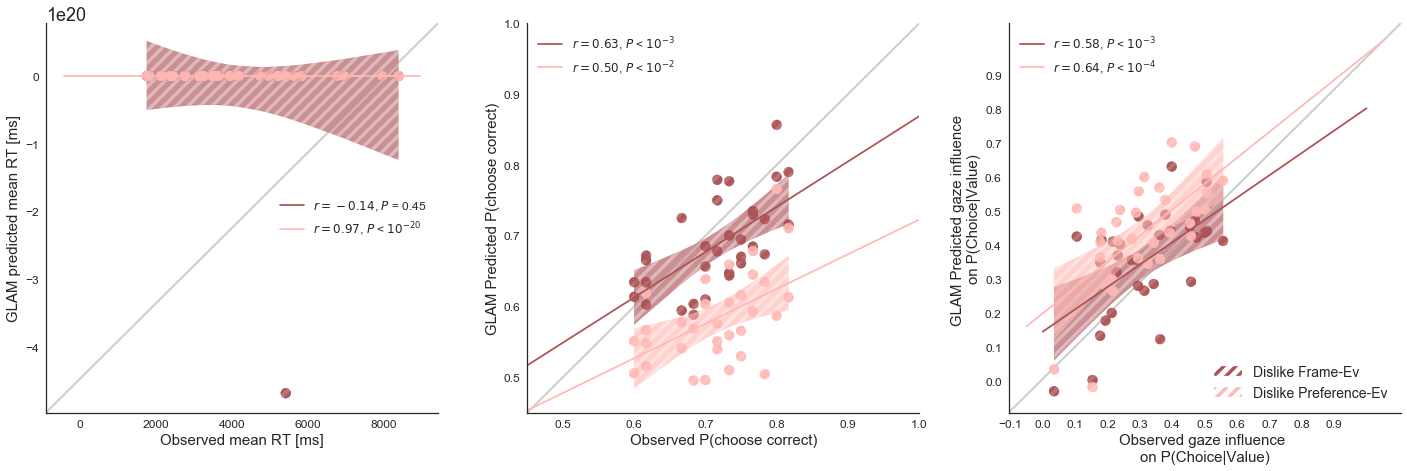

In [30]:
print('Close Figure to continue...')
figure_correlations(mean_rt2, p_choose_best2, gaze_influence2, color_code1 = ['#AC5255', '#FFB9B4'],hatch2 ='//', labels = ['Dislike Frame-Ev','Dislike Preference-Ev'])
#plt.savefig('SavedFigures/Like_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

## ---------------------------------------------

In [21]:
import glam
import pandas as pd
import numpy as np
import os.path
import numpy
import statistics 

import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os



/Users/pradyumna/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/Users/pradyumna/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = mean(data1) - mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("MeanL = "+ str(round(mean(data1),2))+ "; MeanD = "+ str(round(mean(data2),2))+"; [Like - Dislike] =  " + str(round(diff,2) ) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    #fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)

    se1 = std(data1)/sqrt(len(data1))
    se2 = std(data2)/sqrt(len(data2))

    plt.errorbar([1], [mean(data1)], yerr=se1*1.96, lw=2, color='#000000')
    plt.errorbar([2], [mean(data2)], yerr=se2*1.96, lw=2, color='#000000')
        
    plt.scatter( [1] ,  [mean(data1)] , color = c1,s=140,edgecolors = 'black', )
    plt.scatter( [2] ,  [mean(data2)] , color = c2,s=140,edgecolors = 'black', )

    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=25)
    plt.ylabel(title, fontsize=25)
    sns.despine()

In [23]:
gaze_influence

,glam_full_D,glam_full_L,observed_D,observed_L
0,0.264590,0.410089,0.216373,0.216373
1,0.363593,0.132936,0.177232,0.177232
2,0.498295,0.422174,0.475192,0.475192
3,0.507673,0.424905,0.105137,0.105137
4,0.426097,0.292089,0.457899,0.457899
5,0.554142,0.440734,0.507458,0.507458
6,0.600195,0.265449,0.313750,0.313750
7,0.702127,0.630933,0.398298,0.398298
8,-0.018204,0.002693,0.153822,0.153822
9,0.358478,0.122816,0.362603,0.362603


MeanL = 0.32; MeanD = 0.32; [Like - Dislike] =  0.0; t =  nan ; p-value =nan


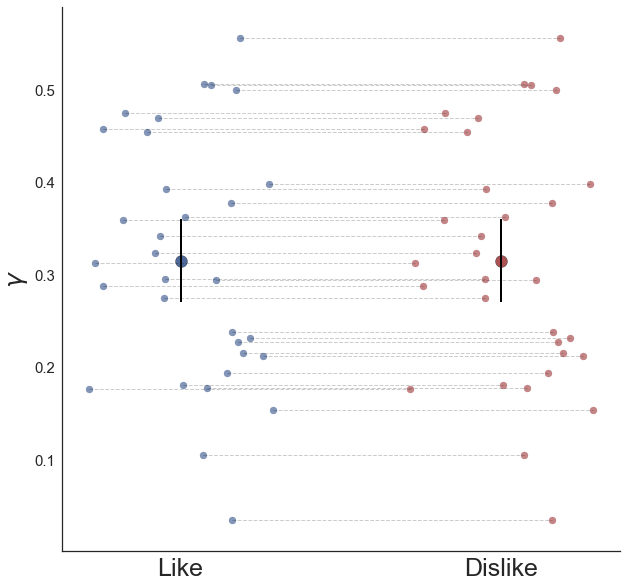

In [24]:
f = plt.figure(figsize=(10,10))
sns.set(style='white', font_scale=1.8)
ttestsPlot(gaze_influence.observed_L, gaze_influence.observed_D,'#4F6A9A','#AC5255',"Like",  "Dislike",title = '$\gamma$')

No difference in gaze influence